# **IMPORTING LIBRARIES**

In [ ]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory

# Other libraries
import os
import random
from PIL import Image

# **LOADING THE DATASET**

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:02<00:00, 101MB/s]
100% 149M/149M [00:02<00:00, 70.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/brain-tumor-mri-dataset.zip")
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = r'/content/Training',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(256, 256),
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = r'/content/Testing',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(256, 256),
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
# Creating a function to visualize the images

def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [ ]:
# Extrating the class labels
classes = train_ds.class_names

# **DATA VISUALISATION**

GLIOMA


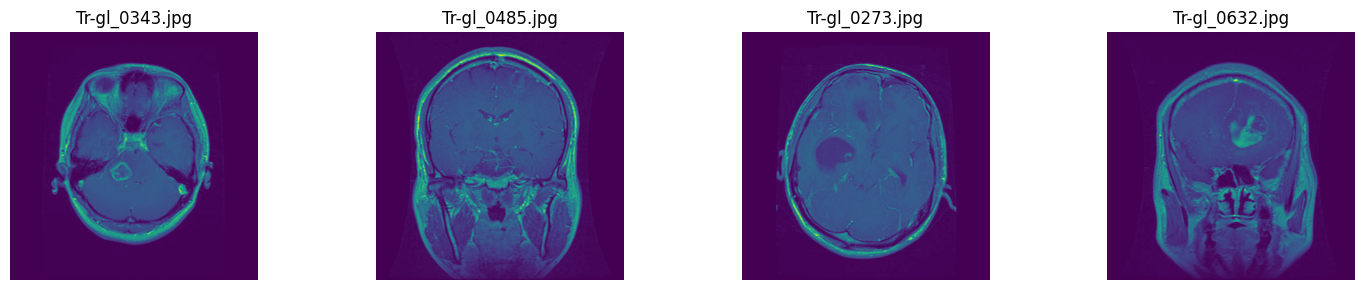

MENINGIOMA


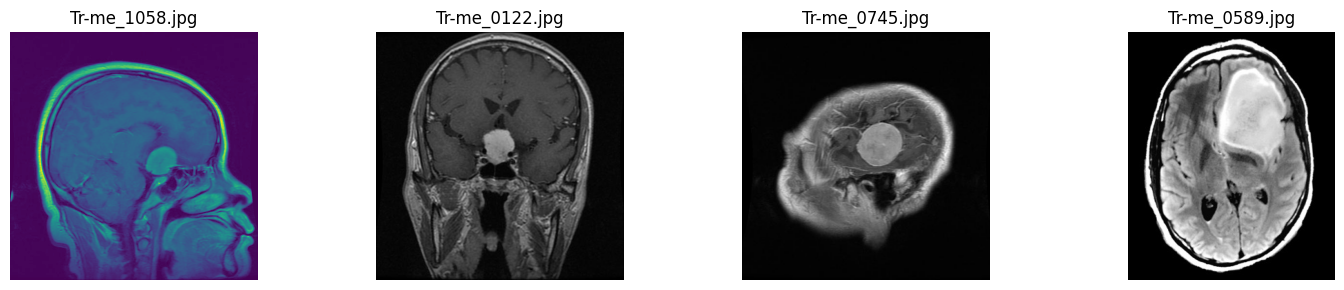

NOTUMOR


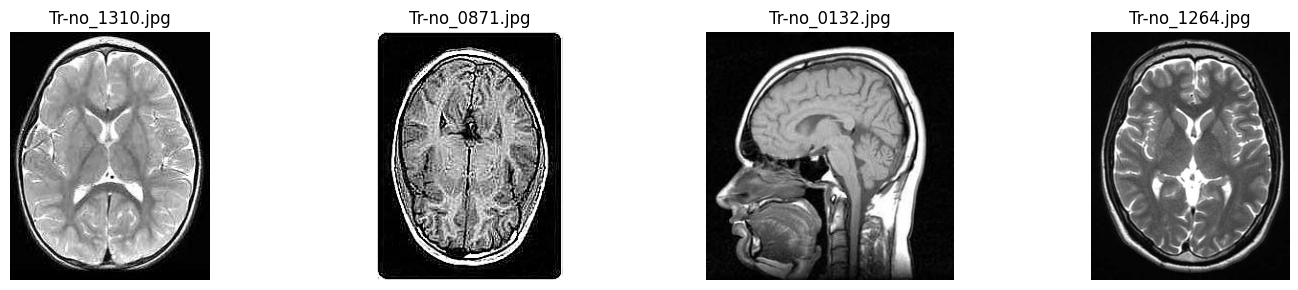

PITUITARY


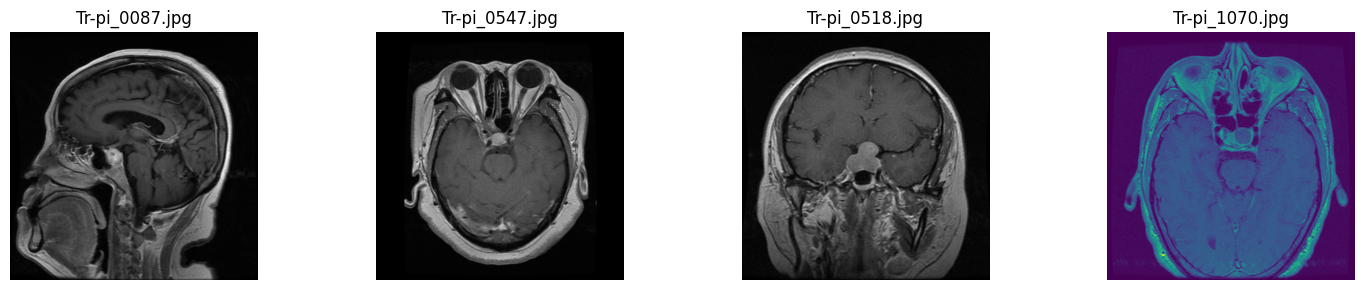

In [ ]:
# Iterating through each class to plot its images
for label in classes:

    # Specify the path containing the images to visualize
    path_to_visualize = f"/content/Training/{label}"

    # Visualize 3 random images
    print(label.upper())
    visualize_images(path_to_visualize, num_images=4)

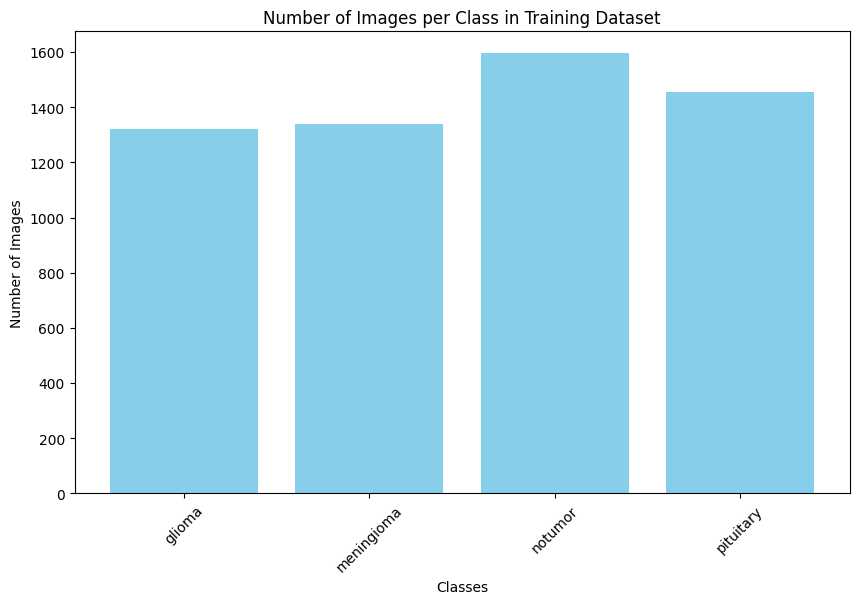

In [ ]:
from collections import Counter

# Initialize a counter for the class labels
label_counts = Counter()

# Iterate through the training dataset to count the labels
for images, labels in train_ds:
    label_counts.update(labels.numpy())

# Convert the counter to a sorted list of tuples (class_index, count)
sorted_label_counts = sorted(label_counts.items())

# Extract class indices and counts
class_indices = [class_index for class_index, _ in sorted_label_counts]
counts = [count for _, count in sorted_label_counts]

# Map class indices to class names
class_names = [classes[i] for i in class_indices]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Dataset')
plt.xticks(rotation=45)  # Rotate labels if they overlap
plt.show()


# **MODEL BUILDING**

# **CNN**

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      58,982,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,396,676 (226.58 MB)

 Trainable params: 59,395,780 (226.58 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds, epochs=15, validation_data=val_ds, verbose=1)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 605ms/step - accuracy: 0.6267 - loss: 6.9463 - val_accuracy: 0.3135 - val_loss: 30.5308
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.8099 - loss: 1.3779 - val_accuracy: 0.6857 - val_loss: 1.2440
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 298ms/step - accuracy: 0.8780 - loss: 0.5288 - val_accuracy: 0.7757 - val_loss: 0.6794
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.9098 - loss: 0.3025 - val_accuracy: 0.8841 - val_loss: 0.3147
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 298ms/step - accuracy: 0.9261 - loss: 0.3422 - val_accuracy: 0.8955 - val_loss: 0.5098
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.9401 - loss: 0.3427 - val_accuracy: 0.8146 - val_loss: 0.7383
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.9428 - loss: 0.3229 - val_accuracy: 0.8665 - val_loss: 0.4001
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - accuracy: 0.9397 - loss: 0.2664 - val_acc

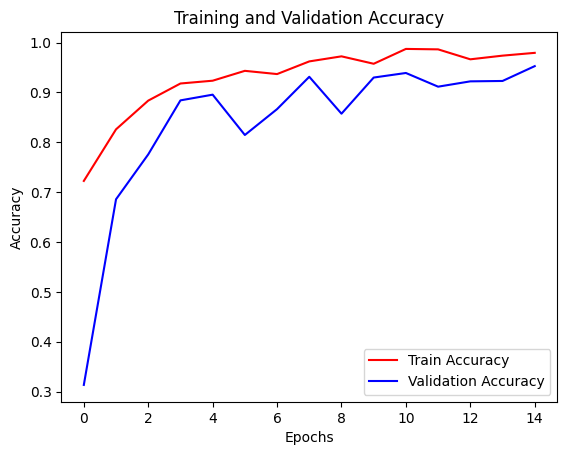

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


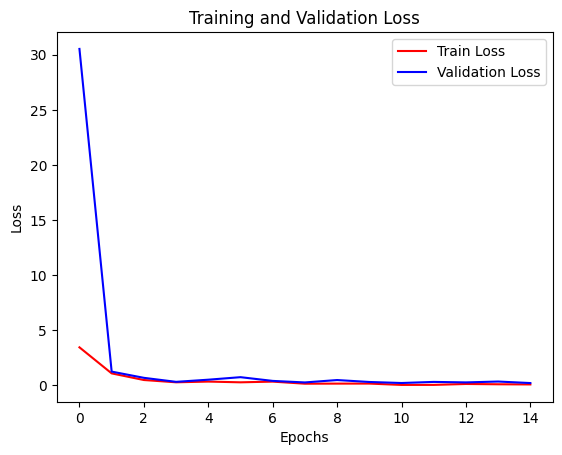

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], color='red', label='Train Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
tr_eval = model.evaluate(train_ds)
tr_loss = tr_eval[0]
tr_acc = tr_eval[1]

val_eval = model.evaluate(val_ds)
val_loss = val_eval[0]
val_acc = val_eval[1]

print("Training Loss:", tr_loss)
print("Training Accuracy:", tr_acc)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9922 - loss: 0.0311
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9507 - loss: 0.1929
Training Loss: 0.026110464707016945
Training Accuracy: 0.9929971694946289
Validation Loss: 0.20518562197685242
Validation Accuracy: 0.952707827091217


# **ResNet**

In [ ]:
def load_images_from_folder(folder, img_height, img_width):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                with Image.open(img_path) as img:
                    img = img.resize((img_width, img_height))
                    img = np.array(img)
                    if img.shape == (img_height, img_width, 3):  # Ensure image is RGB
                        images.append(img)
                        labels.append(label)
    return np.array(images), np.array(labels)

# Parameters
img_height, img_width = 256, 256
train_folder = 'Training/'  # replace with the path to your training data
test_folder = 'Testing/'    # replace with the path to your testing data

# Load training and testing data
x_train, y_train = load_images_from_folder(train_folder, img_height, img_width)
x_test, y_test = load_images_from_folder(test_folder, img_height, img_width)

# Convert labels to numeric format
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (3236, 256, 256, 3)
y_train shape: (3236, 4)
x_test shape: (690, 256, 256, 3)
y_test shape: (690, 4)


In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history2=resnet_model.fit(x_train, y_train, epochs = 15, validation_data = (x_test, y_test))

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9725 - val_loss: 0.1836
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9725 - val_loss: 0.1835
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9710 - val_loss: 0.1970
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9725 - val_loss: 0.1878
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 1.0000 - loss: 9.7756e-04 - val_accuracy: 0.9725 - val_loss: 0.1863
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 8.4891e-04 - val_accuracy: 0.9725 - val_loss: 0.1919
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 1.0000 - loss: 7.3887e-04 - val_accuracy: 0.9725 - val_loss: 0.1946
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.00

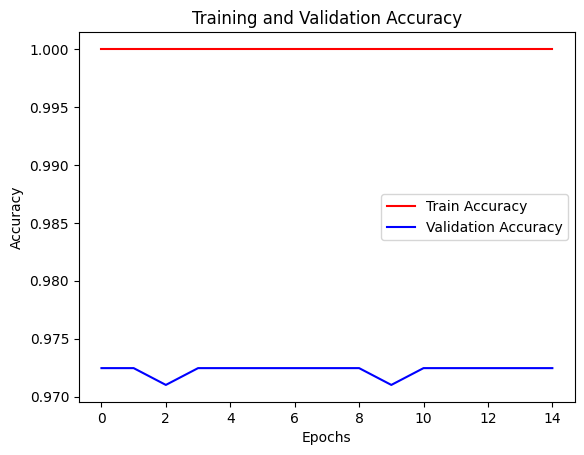

In [ ]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], color='blue', label='Validation Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


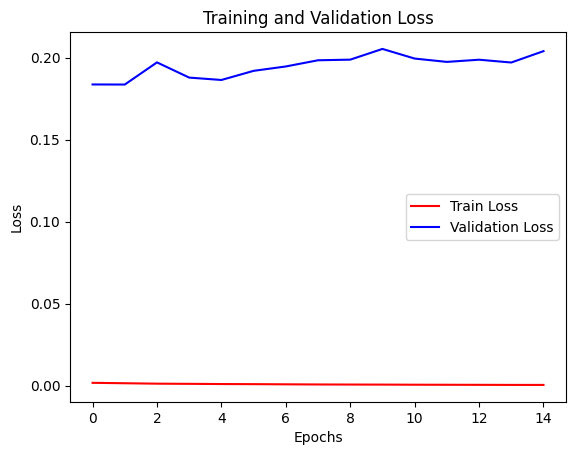

In [ ]:
# Plot training and validation loss
plt.plot(history2.history['loss'], color='red', label='Train Loss')
plt.plot(history2.history['val_loss'], color='blue', label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_loss, test_accuracy = resnet_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

22/22 - 2s - 91ms/step - accuracy: 0.9725 - loss: 0.2039
Test Loss: 0.20389744639396667
Test Accuracy: 0.9724637866020203


# **VGG16**

In [ ]:
# Build the VGG16 model
vgg__model = VGG16(input_shape=(256, 256, 3),
                   include_top=False,
                   weights='imagenet')

# Add custom layers
x = vgg__model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Number of classes is 4

# Create the model
vgg_model = Model(inputs=vgg__model.input, outputs=predictions)

# Print the model summary
vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 15,244,100 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vgg_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history3=vgg_model.fit(x_train, y_train, epochs = 40, validation_data = (x_test, y_test))

Epoch 1/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.4849 - loss: 5.0213 - val_accuracy: 0.5855 - val_loss: 1.0648
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 577ms/step - accuracy: 0.7153 - loss: 0.7990 - val_accuracy: 0.5754 - val_loss: 0.9717
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.7795 - loss: 0.6162 - val_accuracy: 0.6725 - val_loss: 0.7816
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 574ms/step - accuracy: 0.8189 - loss: 0.4836 - val_accuracy: 0.6884 - val_loss: 0.7510
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.8190 - loss: 0.5039 - val_accuracy: 0.7478 - val_loss: 0.6198
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.8578 - loss: 0.4167 - val_accuracy: 0.7739 - val_loss: 0.6420
Epoch 7/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.8770 - loss: 0.3448 - val_accuracy: 0.7928 - val_loss: 0.6401
Epoch 8/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 578ms/step - accuracy: 0.8925 - loss: 0.3

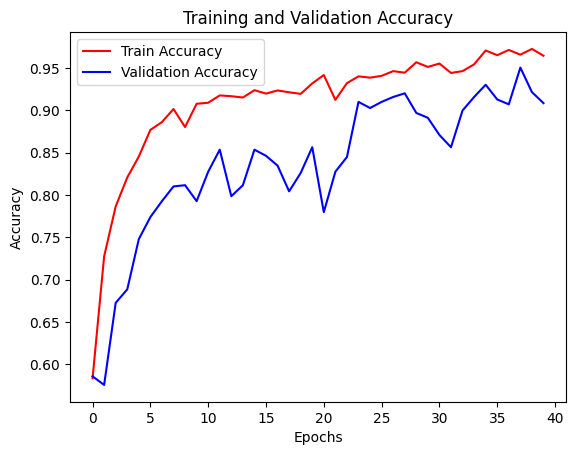

In [ ]:
# Plot training and validation accuracy
plt.plot(history3.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], color='blue', label='Validation Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


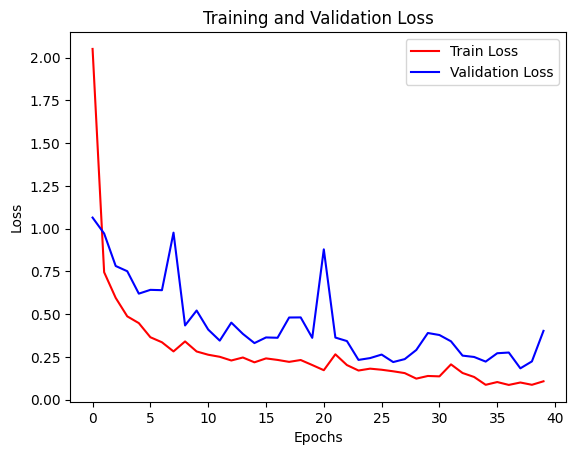

In [ ]:
# Plot training and validation loss
plt.plot(history3.history['loss'], color='red', label='Train Loss')
plt.plot(history3.history['val_loss'], color='blue', label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

22/22 - 3s - 138ms/step - accuracy: 0.9087 - loss: 0.4020
Test Loss: 0.4020330011844635
Test Accuracy: 0.908695638179779


# **IMAGE SEGMENTATION**

# **UNet**

In [ ]:
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset
License(s): CC-BY-SA-4.0
 99% 834M/839M [00:17<00:00, 25.2MB/s]
100% 839M/839M [00:17<00:00, 51.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/figshare-brain-tumor-dataset.zip")
zip_ref.extractall('/content')
zip_ref.close()

150.mat
300.mat
450.mat
600.mat
750.mat
900.mat
1050.mat
1200.mat
1350.mat
1500.mat
1650.mat
1800.mat
1950.mat
2100.mat
2250.mat
2400.mat
2550.mat
2700.mat
2850.mat
3000.mat
Finished
(3064,)
[ 708 1426  930]


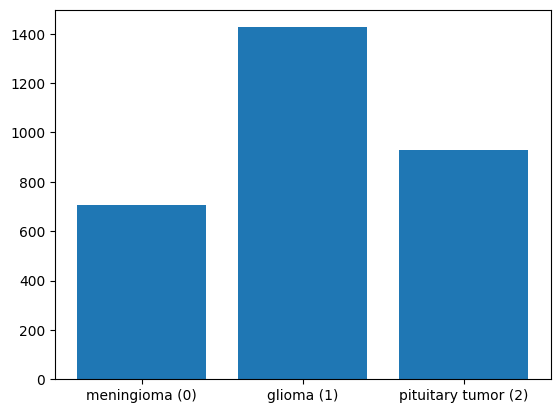

In [ ]:
import h5py
data_dir= '/content/dataset/data'
total_image=3064
datalist=[]
labels=[]

for i in range(1,total_image+1):

  filename=str(i)+".mat"

  data=h5py.File(os.path.join(data_dir,filename),"r")

  datalist.append(data)

  if i%150==0:
    print(filename)
  if i == 3063:
    print("Finished")

for i  in range(total_image):
  label =int(datalist[i]["cjdata"]["label"][()])-1

  labels.append(label)

labels=np.array(labels)


print(labels.shape)

num_to_class = {'0': 'meningioma (0)',
                '1': 'glioma (1)',
                '2': 'pituitary tumor (2)'}
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(num_to_class.values()))
print(counts)


In [ ]:
counts

array([ 708, 1426,  930])

In [ ]:
from skimage.transform import resize

masks = []
for i in range(total_image):
  mask = datalist[i]["cjdata"]["tumorMask"][()]
  mask = np.expand_dims(resize(mask, (128, 128), mode="constant", preserve_range=True), axis=-1)
  masks.append(mask)

print(len(masks))
masks=np.array(masks)
print(masks.shape)

3064
(3064, 128, 128, 1)


In [ ]:
images = []
for i in range(total_image):
  im = datalist[i]["cjdata"]["image"][()]
  im = np.expand_dims(resize(im, (128, 128), mode="constant", preserve_range=True), axis=-1)
  images.append(im)

print(len(images))
images=np.array(images)
print(images.shape)

3064
(3064, 128, 128, 1)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


input_shape = images[0].shape # input shape
input_shape
x_train, x_test, y_train, y_test= train_test_split (images,masks,test_size=0.2, shuffle= True)
x_train.shape
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()
#augment
x_train= np.append( x_train, [ np.fliplr(x) for x in  x_train], axis=0 )
y_train = np.append( y_train, [ np.fliplr(y) for y in  y_train], axis=0 )
x_train.shape, y_train.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    # Expand input to 3 channels
    if input_shape[-1] == 1:
        expanded_input = Concatenate()([inputs, inputs, inputs])  # Concatenate along channel dimension
    else:
        expanded_input = inputs

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=expanded_input)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

# Example usage:
input_shape = (128, 128, 1)  # Input shape with 1 channel
model = build_vgg19_unet(input_shape)
model.summary()

Model: "VGG19_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 128, 128, 3)    │              0 │ input_layer_3[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_3[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)

 Total params: 31,172,033 (118.91 MB)

 Trainable params: 31,168,193 (118.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1. - dice


### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             loss=bce_dice_loss, metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from keras import backend as K


model_checkpoint = ModelCheckpoint('model_best_checkpoint.keras', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

#train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
#val_generator = val_datagen.flow(x_test, y_test, batch_size=32)

hist = model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=5,batch_size=32)

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 171s 719ms/step - accuracy: 0.9628 - loss: 1.0921 - val_accuracy: 0.9765 - val_loss: 0.7027
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 480ms/step - accuracy: 0.9764 - loss: 0.5801 - val_accuracy: 0.9784 - val_loss: 0.4154
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 478ms/step - accuracy: 0.9791 - loss: 0.4170 - val_accuracy: 0.9800 - val_loss: 0.3975
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - accuracy: 0.9807 - loss: 0.3509 - val_accuracy: 0.9791 - val_loss: 0.3668
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - accuracy: 0.9811 - loss: 0.3206 - val_accuracy: 0.9815 - val_loss: 0.2991


In [ ]:
hist = model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=2,batch_size=32)

Epoch 1/2
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 476ms/step - accuracy: 0.9819 - loss: 0.2847 - val_accuracy: 0.9806 - val_loss: 0.4204
Epoch 2/2
154/154 ━━━━━━━━━━━━━━━━━━━━ 84s 491ms/step - accuracy: 0.9823 - loss: 0.2615 - val_accuracy: 0.9787 - val_loss: 0.3420


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step


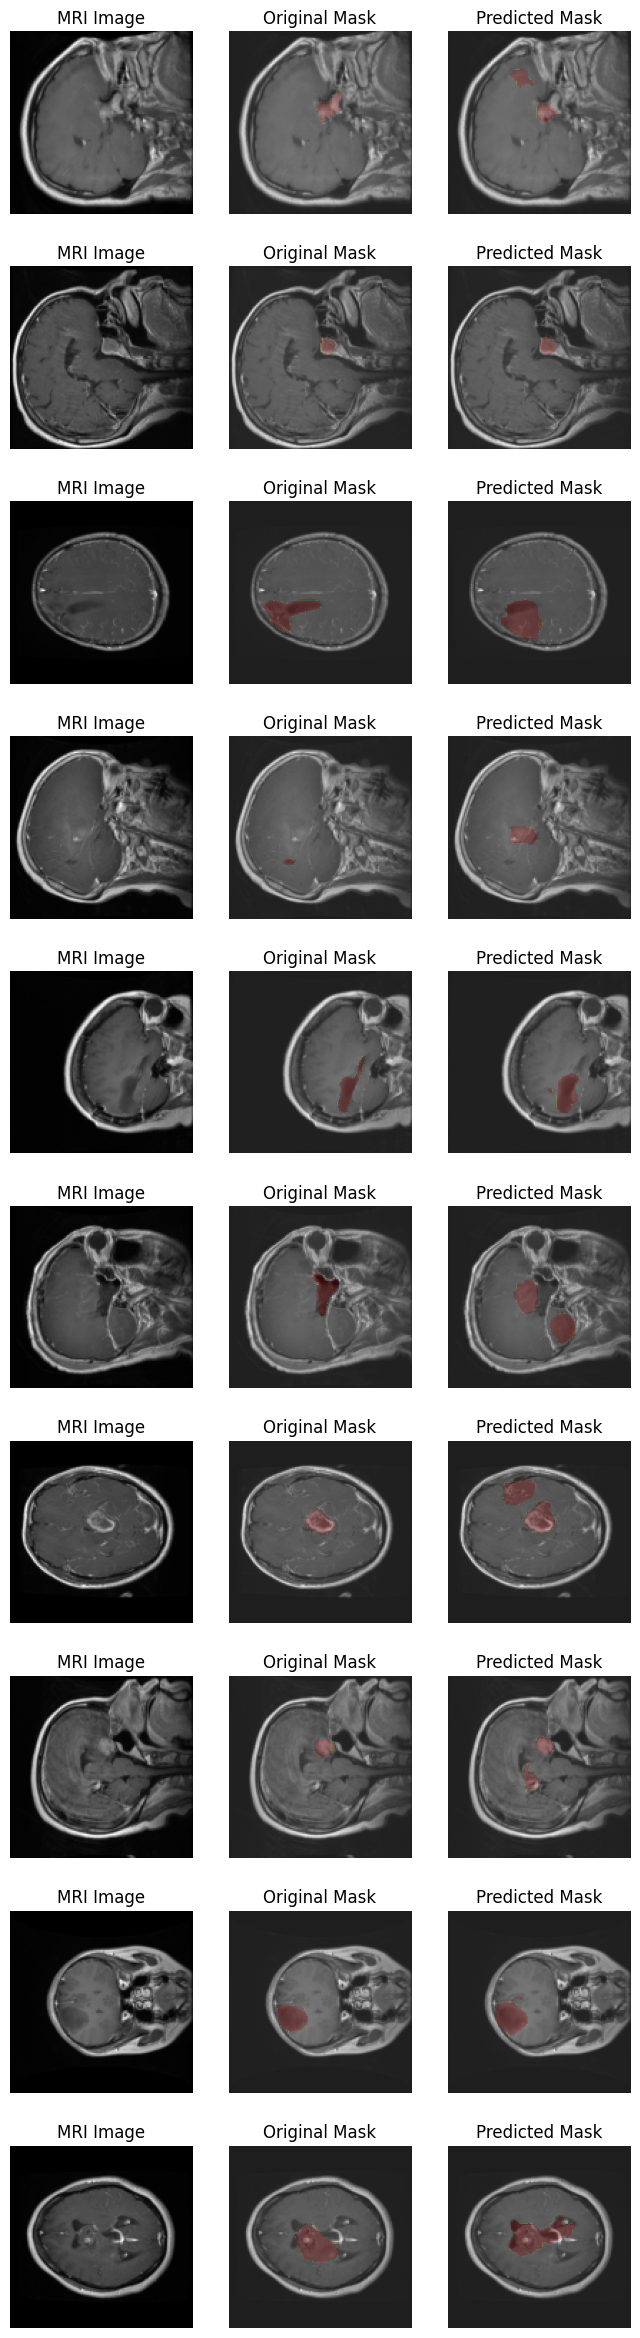

In [ ]:
THRESHOLD = 0.3
predicted_mask = (model.predict(x_test)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like(y_test[0] )
for idx in np.random.randint(0,high=x_test.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - y_test[idx], alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - predicted_mask[idx],  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

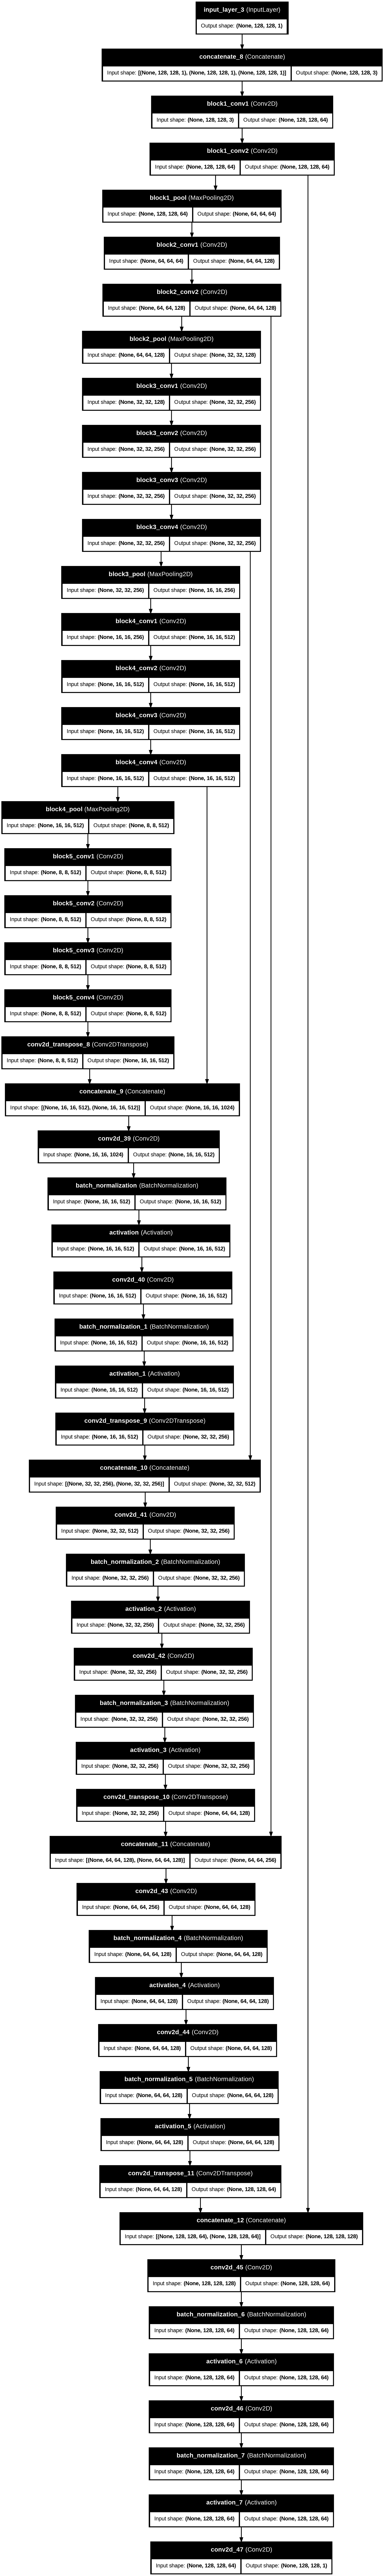

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_segnet.png', show_shapes=True, show_layer_names=True)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


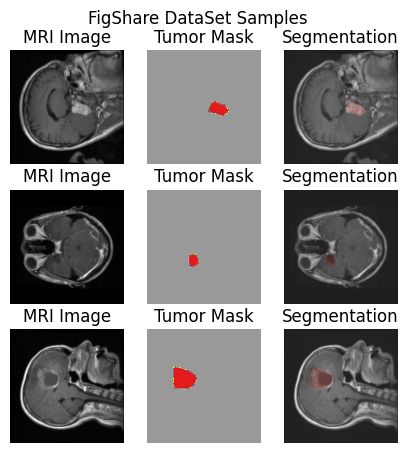

In [ ]:
THRESHOLD = 0.3
predicted_mask = (model.predict(x_test)>THRESHOLD)*1
fig = plt.figure(figsize=(5,5))
fig.suptitle("FigShare DataSet Samples")
plt.subplots_adjust(top=0.9)

i=1;total=3
temp = np.ones_like(y_test[0] )
for idx in np.random.randint(0,high=x_test.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - y_test[idx], alpha=1, cmap='Set1' )
    plt.title("Tumor Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - y_test[idx], alpha=0.2, cmap='Set1' )
    plt.title("Segmentation");plt.axis('off')